In [1]:
import numpy as np
from src.cost import LogCost
from src.cpop import CPOP
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

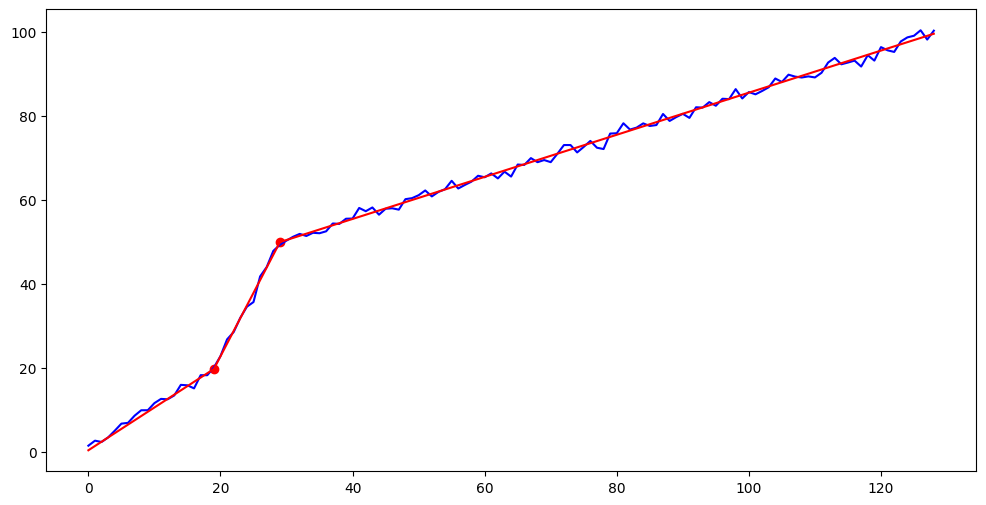

In [2]:
y = np.concatenate([np.arange(1, 20), np.arange(20, 50, 3), np.arange(50, 100, 0.5)])
y += np.random.randn(len(y))
h = LogCost(1)
sigma = 1
beta = 200

detector = CPOP(y, sigma, beta, h)
output = detector.run()
detector.compute_approx_and_plot()

In [3]:
import pandas as pd
import json

df = pd.read_csv("../data/gdp.csv", skiprows=4)

In [4]:
sdf = df[df["Country Name"]=="Argentina"]

columns_years = [col for col in sdf.columns if col.isdigit()]
ts = sdf.loc[:, columns_years]

serie = ts.reset_index(drop=True).T
y = serie[0].to_numpy()

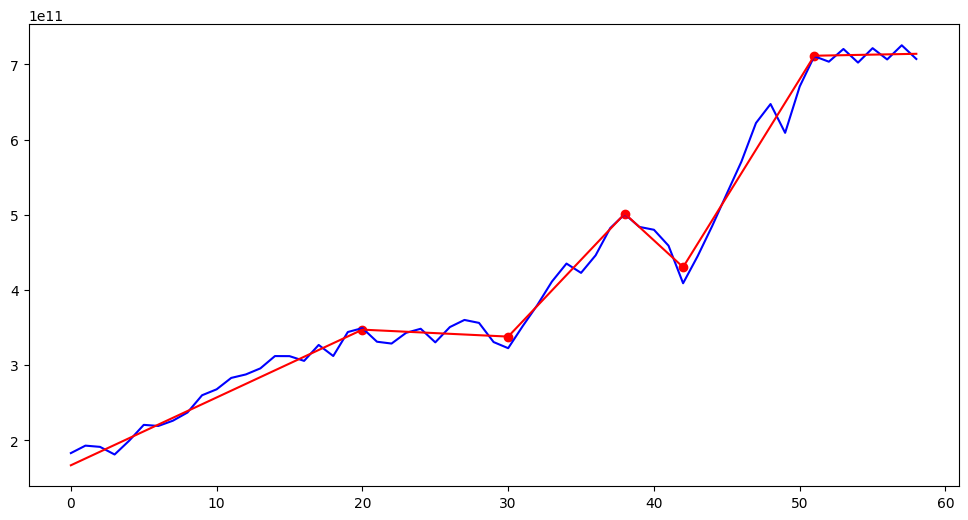

BIC:  2950.403602856342


In [6]:
h = LogCost(1)
sigma = median_abs_deviation(serie[0].diff()[1:])
beta = 10

detector = CPOP(y, sigma, beta, h)
output = detector.run()
detector.compute_approx_and_plot()
print("BIC: ", float(detector.BIC()))

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:01<00:00, 29.70it/s]


Beta for min BIC: 3.0
BIC: 2940.479295550103


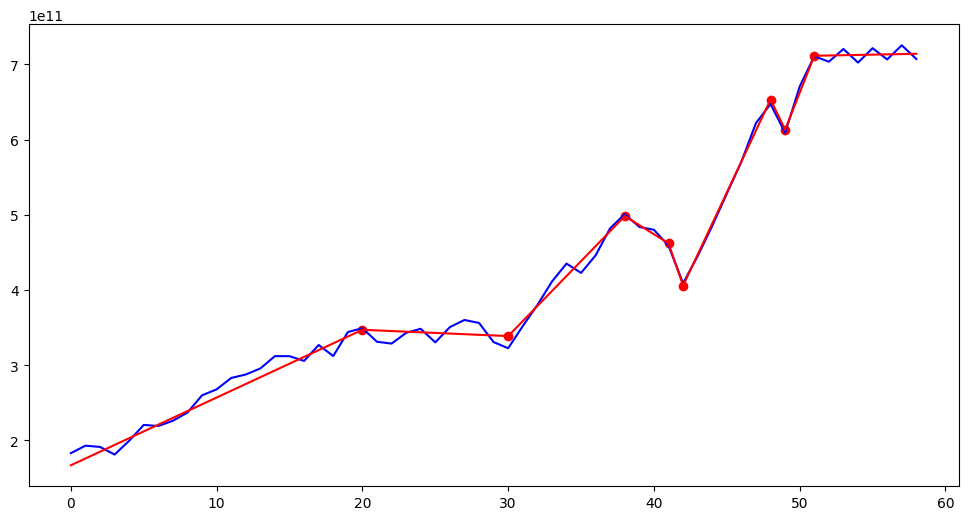

In [7]:
detector.compute_max_criterion(beta_range=np.linspace(0.5, 20, 40), criterion="BIC")

## GDP IRAN

In [9]:
with open("../data/gdp_iran.json", "r") as file:
    data = json.load(file)

In [10]:
gdp_iran = np.array(data["series"][0]["raw"])
sigma = median_abs_deviation(np.diff(gdp_iran))


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 21.62it/s]


Beta for min mBIC: 20.302215052732095
mBIC: 4052.6553859572127


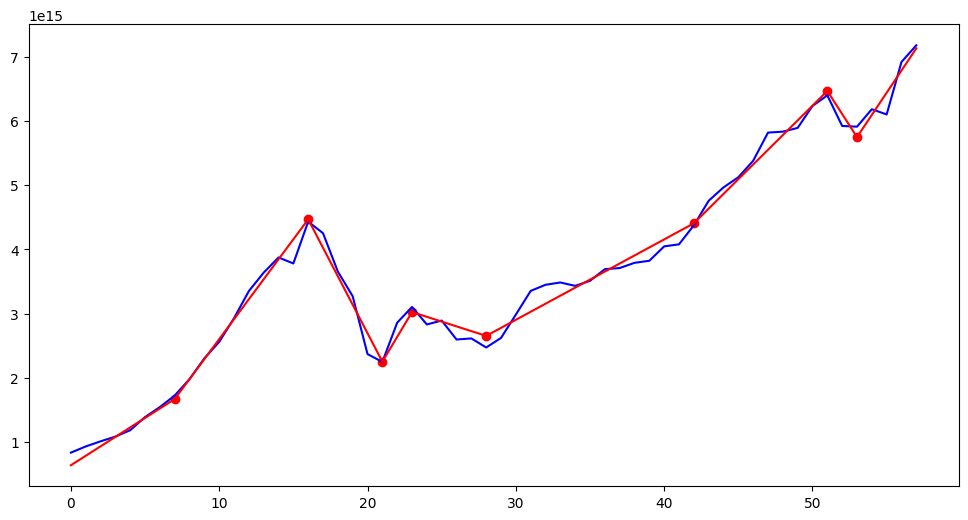

In [11]:
gdp_iran = np.array(data["series"][0]["raw"])
sigma = median_abs_deviation(np.diff(gdp_iran))


h = LogCost(1)

beta = 10

detector = CPOP(gdp_iran, sigma, beta, h)
detector.compute_max_criterion(log_n=True, beta_range=np.linspace(5,21, 15), criterion="mBIC")

## Bitcoin

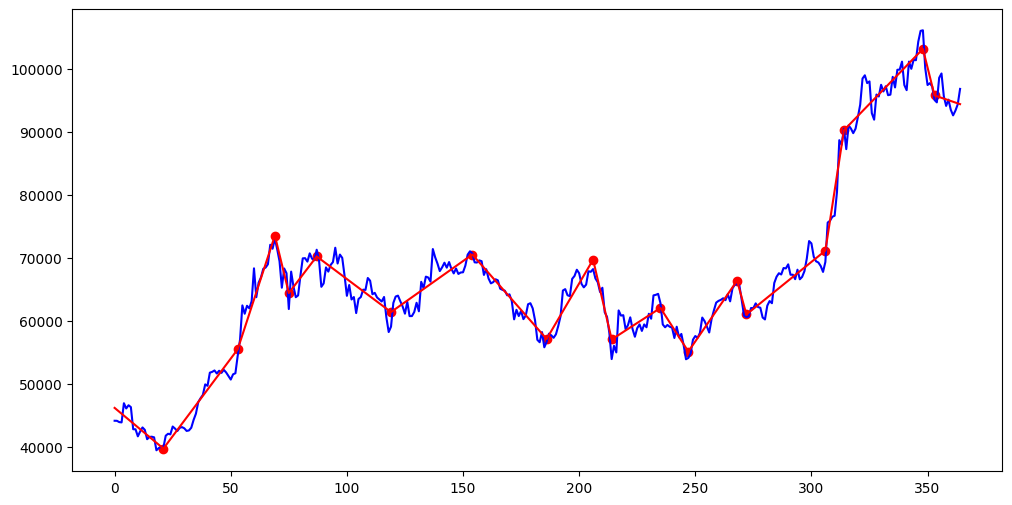

np.float64(7289.925522230605)

In [ ]:

with open("../data/market-price.json", "r") as file:
    data = json.load(file)

market_price_data = data["market-price"]

df = pd.DataFrame(market_price_data)

df.rename(columns={"x": "timestamp", "y": "value"}, inplace=True)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')

y = df["value"].to_numpy()


h = LogCost(0.01)
sigma = median_abs_deviation(np.diff(y))
beta = 50 * np.log(len(y))

detector = CPOP(y, sigma, beta, h)
output = detector.run()
detector.compute_approx_and_plot()
detector.mBIC()

100%|██████████| 95/95 [00:34<00:00,  2.75it/s]


Beta for min mBIC: 29.499486767912458
mBIC: 6911.348753108274


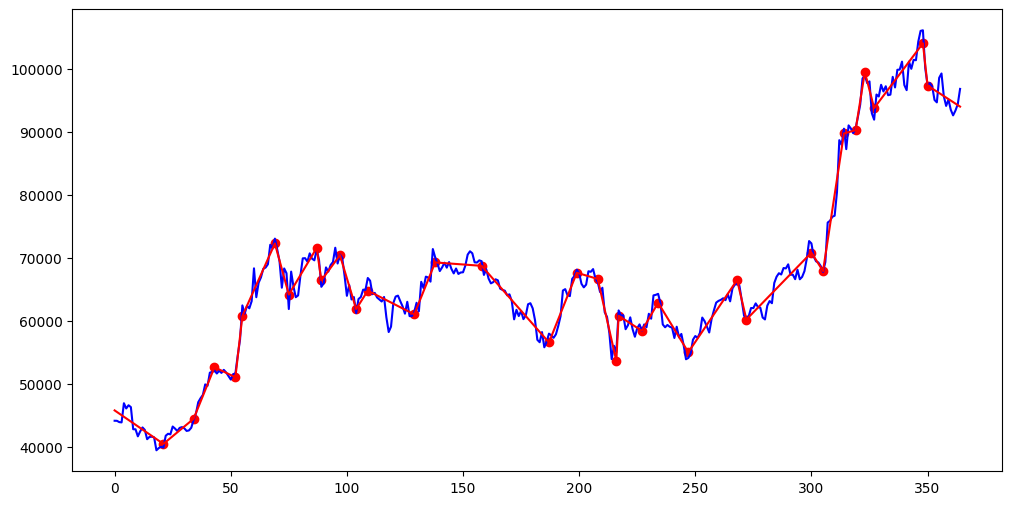

In [18]:
detector.compute_max_criterion(beta_range=np.linspace(5, 100, 95), criterion="mBIC", log_n=True)

## Euro Stock 50

[*********************100%***********************]  1 of 1 completed


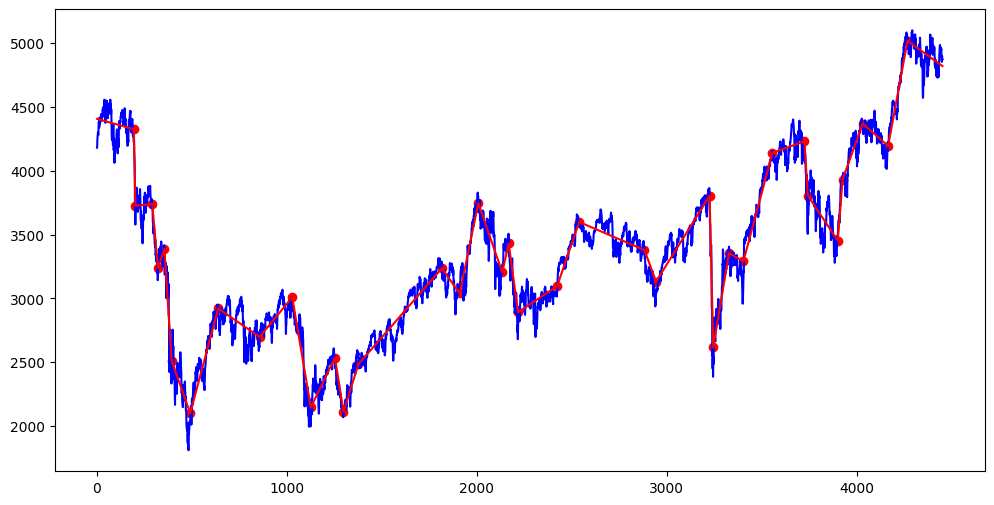

np.float64(63078.91654653814)

In [20]:
import yfinance as yf

euro_stoxx_50 = yf.download('^STOXX50E',
                            start = "2005-01-01",
                            )['Close']

y = euro_stoxx_50["^STOXX50E"].to_numpy()
sigma = euro_stoxx_50["^STOXX50E"].diff().std()
beta = 50*np.log(len(y))
h = LogCost(2)
detector = CPOP(y, sigma, beta, h)
output = detector.run()
detector.compute_approx_and_plot()
detector.mBIC()

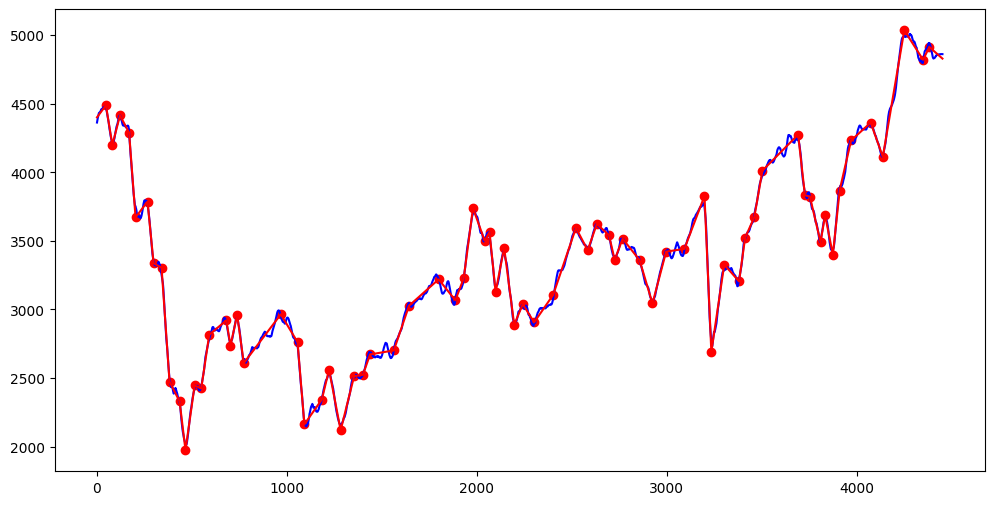

np.float64(78776.03472621305)

In [21]:
from src.utils import ssa_approx

serie = ssa_approx(y, m=1)
sigma = np.diff(serie).std()
beta = 200*np.log(len(y))
h = LogCost(0.01)
detector = CPOP(serie, sigma, beta, h)
output = detector.run()
detector.compute_approx_and_plot()
detector.BIC()

## Others Algorithms
#TODO compléter cette partie

In [22]:
from src.pelt import PELT
from src.cost import cost_L2

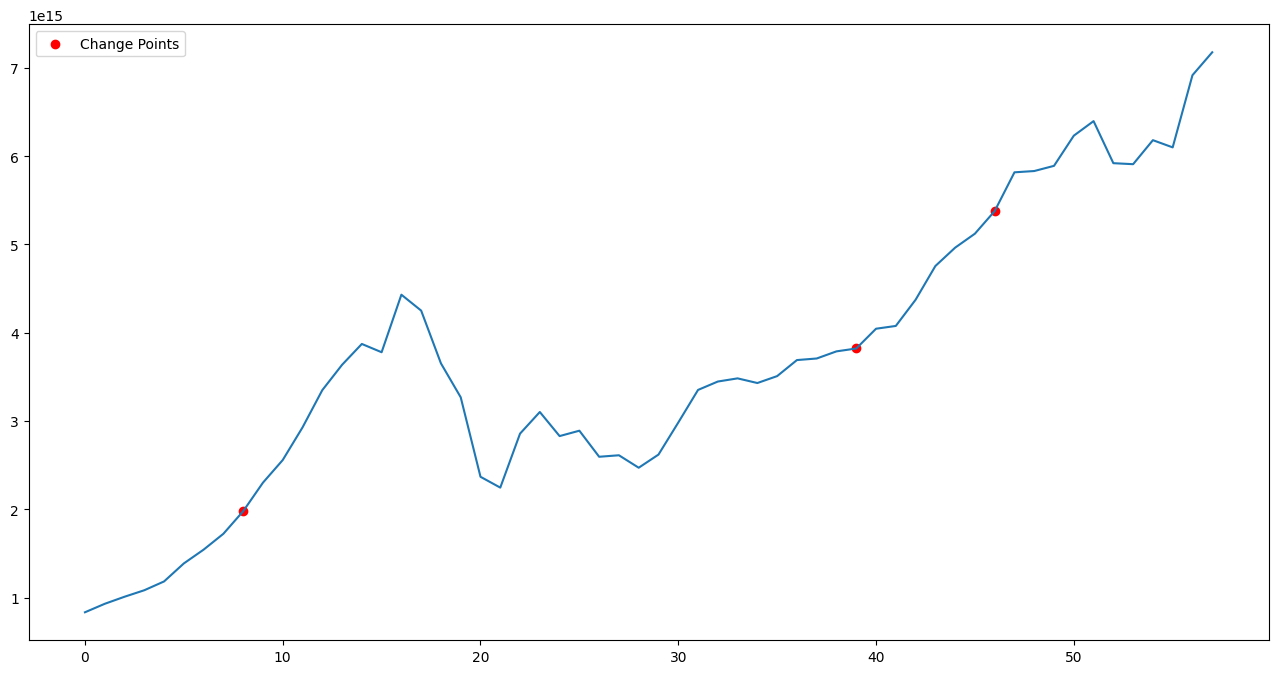

In [27]:
pelt = PELT(gdp_iran, cost_L2, 12)
pelt.run()
pelt.show_changepoints(3)

100%|██████████| 4452/4452 [02:28<00:00, 30.05it/s] 


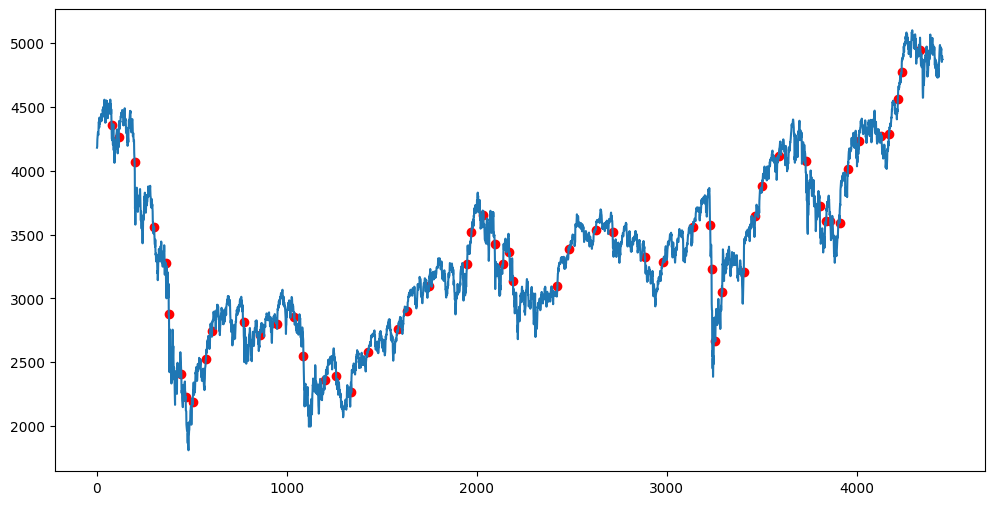

In [26]:
from tqdm import tqdm 
def OP_CPD(x, cost, beta):
    # Initialization 
    n = len(x)
    T = np.empty(n, dtype=int) 
    T[0] = 0 
    F = np.empty(n+1)
    F[0] = -beta 
    F[1] = cost(x[0])

    # Compute T and F
    for t in tqdm(range(2, n+1)):
        cost_array = np.empty(t)
        for s in range(t):
            cost_array[s] = F[s] + cost(x[s:t]) + beta 
        T[t-1] = np.argmin(cost_array)  # Last optimal change point of (x_1, ..., x_t) ==> it's a position, not an index here!
        F[t] = cost_array[T[t-1]]       # Cost for choosing optimal change points of (x_1, ..., x_t) 
    
    # Compute the optimal change points 
    CP = [T[-1]]
    while CP[0] != 0:        
        CP.insert(0, T[CP[0]-1])
    CP = np.array(CP[1:])
    CP -= 1  # We turn the positions into indices 
    
    # Return CP
    return CP

sigma = np.diff(y).std()
plt.figure(figsize=(12, 6))
plt.plot(y)
output = OP_CPD(y/sigma, cost_L2, 200)
plt.scatter(output, y[output], c="r")